In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Import Dataset

In [3]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [4]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [37]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [40]:
def objective(space):
    clf=XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(X_test)
    accuracy = r2_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [42]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.745960746378051, 'gamma': 1.3923603730315932, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 40.0, 'reg_lambda': 0.6953412838096322}


In [5]:
# Grid Search
param_grid={'eta': np.random.uniform (0.01, 0.2, size=5),
        'max_depth': range(3, 10, 2),
        'gamma': np.random.uniform (1, 9, size=5),
        'reg_alpha': range(10, 40, 10),
        'reg_lambda': np.random.uniform (0, 1, size=5),
        'colsample_bytree': np.random.uniform (0.5, 1, size=5),
        'min_child_weight': range(0, 10, 2)
    }

xgb = XGBRegressor(n_jobs=-1, random_state=42)
xgb_grid = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, cv=8, n_jobs=-1, verbose=3,)
                              # scoring='neg_root_mean_squared_error')

In [6]:
xgb_grid.fit(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RandomizedSearchCV(cv=8,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                   param_distributions={'colsample_bytree': array([0.6384119 , 0.74974631, 0.68708772, 0.77891754, 0.81555786]),
                                        'eta': array([0.11632857, 0.10257472, 0.13637108, 0.05972944, 0.02268481]),
                                        'gamma': array([5.61203162, 1.97176365, 5.3960901 , 3.69677537, 4.81571699]),
                                        'max_depth': range(3, 10, 2),
                                        'min_child_weight': range(0, 10, 2),
                                        'reg_alpha': range(10, 40, 10),
                                        'reg_lambda': array([0.56818288, 0.10331385, 0.18764434, 0.55280907, 0.8602244 ])},
                   verbose=3)

In [7]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)

{'reg_lambda': 0.8602243958789016, 'reg_alpha': 10, 'min_child_weight': 0, 'max_depth': 7, 'gamma': 5.396090096317051, 'eta': 0.11632856926715154, 'colsample_bytree': 0.6870877248325737}
0.9370446894246394


In [8]:
import pickle

with open('./data/ml_weights/xgb_best_model', "wb") as fp:
    pickle.dump(xgb_grid.best_estimator_, fp)

In [10]:
import pickle

with open('./data/ml_weights/xgb_best_model', "rb") as fp:
    xgb_grid = pickle.load(fp)

C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


NSE: 0.9783, R2: 0.9791, PBias: 1.1250, MSE: 0.9091


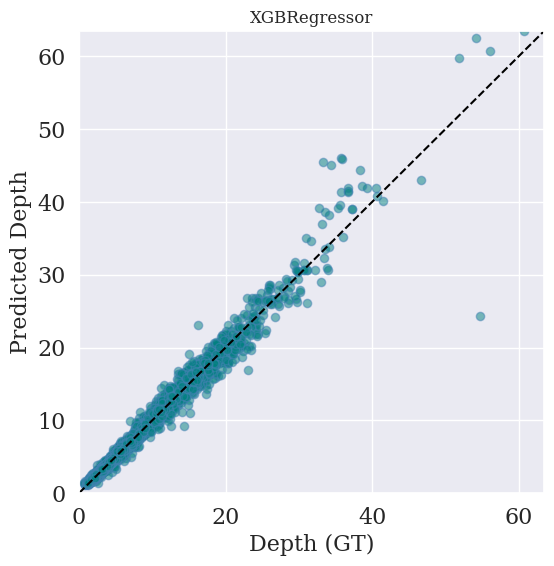

In [11]:
xgb_pred = xgb_grid.predict(X_test)
scatter_plot(y_test, xgb_pred, model_name='XGBRegressor')